# Shor's Algorithm with Qiskit and Quantum Rings Backend
This notebook demonstrates a full implementation of Shor's Algorithm using Qiskit. It includes a true modular exponentiation circuit using controlled arithmetic gates and executes on the Quantum Rings backend.

In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from math import gcd
import numpy as np
import random

def get_random_coprime(N):
    while True:
        a = random.randint(2, N - 1)
        if gcd(a, N) == 1:
            return a


In [2]:
from qiskit import QuantumCircuit
from math import pi

def cuccaro_adder(n):
    def adder_circuit():
        qc = QuantumCircuit(2*n + 1, name="CuccaroAdd")

        a = list(range(n))           # input a
        b = list(range(n, 2*n))      # input b (will hold the result)
        cin = 2*n                    # carry bit

        # Forward carry
        for i in range(n):
            qc.cx(a[i], b[i])
            qc.ccx(a[i], b[i], cin)

        # Backward uncompute
        for i in reversed(range(n)):
            qc.ccx(a[i], b[i], cin)
            qc.cx(a[i], b[i])

        return qc.to_gate()
    return adder_circuit()

In [3]:
def quantum_comparator(n):
    qc = QuantumCircuit(2 * n + 1, name="Compare")

    x = list(range(n))
    y = list(range(n, 2 * n))
    out = 2 * n

    for i in reversed(range(n)):
        qc.cx(y[i], x[i])
        qc.ccx(x[i], y[i], out)
        qc.cx(y[i], x[i])

    return qc.to_gate()

In [4]:
def reversible_mod_add(a, N, n):
    qc = QuantumCircuit(2*n + 2, name=f"ModAdd({a})")

    x = list(range(n))
    tmp = list(range(n, 2*n))
    flag = 2*n
    anc = 2*n + 1

    # Encode a into tmp using X gates
    for i in range(n):
        if (a >> i) & 1:
            qc.x(tmp[i])

    # Add tmp (a) to x using Cuccaro adder
    adder = cuccaro_adder(n)
    qc.append(adder, x + tmp + [anc])

    # Compare (x + a >= N)?
    comparator = quantum_comparator(n)
    qc.append(comparator, x + tmp + [flag])

    # Conditionally subtract N using Cuccaro adder
    for i in range(n):
        if (N >> i) & 1:
            qc.x(tmp[i])  # prepare tmp = N

    qc.append(adder.inverse().control(1), [flag] + x + tmp + [anc])

    # Uncompute tmp
    for i in range(n):
        if (N >> i) & 1:
            qc.x(tmp[i])
        if (a >> i) & 1:
            qc.x(tmp[i])

    return qc.to_gate()

In [5]:
def reversible_mod_mult(a, N, n):
    total_qubits = 3 * n + 3
    qc = QuantumCircuit(total_qubits, name=f"ModMult({a})")

    x    = list(range(n))                         # input x
    acc  = list(range(n, 2 * n))                  # accumulator
    flag = 2 * n
    anc  = 2 * n + 1
    tmp  = list(range(2 * n + 2, 3 * n + 2))       # scratch space for constant

    for i in range(n):
        shifted = (a * (2 ** i)) % N
        modadd = reversible_mod_add(shifted, N, n)
        qc.append(modadd.control(1), [x[i]] + acc + tmp + [flag, anc])

    return qc.to_gate()

In [6]:
# Full modular exponentiation circuit using controlled modular multipliers
def modular_exponentiation(a, N, n, t):
    """
    Applies a sequence of controlled modular multiplications:
    U^{2^i} = (a^{2^i}) mod N for i in [0, t-1]
    """
    # Total qubits: t (control) + n (work) + 1 (ancilla)
    qc = QuantumCircuit(t + n + 1)

    for i in range(t):
        a_exp = pow(a, 2**i, N)
        mod_gate = reversible_mod_mult(a_exp, N, n)  # expects n+2 qubits
        # Assign:
        # control qubit: i
        # work register: [t, t+1, ..., t+n-1]
        # ancilla: t+n
        qubit_indices = [i] + list(range(t, t + n)) + [t + n]
        qc.append(mod_gate, qubit_indices)

    return qc


In [7]:
# Full Shor's quantum circuit using QFT and modular exponentiation
def shor_quantum_circuit(a, N):
    n = N.bit_length()
    t = 2 * n
    total_qubits = t + 3*n + 3  # counting + controlled modular exp
    qc = QuantumCircuit(total_qubits, t)

    # Superposition on counting
    for i in range(t):
        qc.h(i)

    # Initialize x input register to |1⟩
    qc.x(t)  # x[0] = |1⟩

    # Controlled-U^{2^i}
    for i in range(t):
        a_exp = pow(a, 2**i, N)
        mod_gate = reversible_mod_mult(a_exp, N, n)
        control = i
        modexp_indices = list(range(t, t + 3*n + 3))  # ✅ this is 3n + 3
        qc.append(mod_gate.control(1), [control] + modexp_indices)  # ✅ passes 3n + 4

    # Inverse QFT
    qc.append(QFT(t, inverse=True).decompose(), range(t))
    qc.measure(range(t), range(t))

    return qc


In [8]:
import QuantumRingsLib
from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2
from quantumrings.toolkit.qiskit import QrJobV1

provider = QuantumRingsProvider(token="OMITTED", name="-")
backend = QrBackendV2(provider, num_qubits=200)
provider.active_account()
shots = 1024

In [9]:
def plot_histogram (counts, title=""): 
    from matplotlib import pyplot as plt
    import numpy as np
    fig, ax = plt.subplots(figsize =(10, 7))
    plt.xlabel("States")
    plt.ylabel("Counts")
    mylist = [key for key, val in counts.items() for _ in range(val)]

    unique, inverse = np.unique(mylist, return_inverse=True)
    bin_counts = np.bincount(inverse)

    plt.bar(unique, bin_counts)

    maxFreq = max(counts.values())
    plt.ylim(ymax=np.ceil(maxFreq / 10) * 10 if maxFreq % 10 else maxFreq + 10)
    # Show plot
    plt.title(title)
    plt.show()
    return

In [10]:
# Run Shor's algorithm with retries until successful
def shor(N):
    a = get_random_coprime(N)
    print(f"Trying a = {a}")
    qc = shor_quantum_circuit(a, N)

    qc_transpiled = transpile(qc, backend, initial_layout=[i for i in range(0, qc.num_qubits)])
    job = backend.run(qc_transpiled, shots = shots)
    
    result = job.result()
    counts = result.get_counts()
    plot_histogram(counts)

    print(qc)

    return counts
    
    #measured = list(counts.keys())[0]
    #factors = get_factors_from_result(measured, a, N)
    #if factors:
        #print(f"Success: {N} = {factors[0]} × {factors[1]}")
        #return factors

def printGate(N):
    a = get_random_coprime(N)
    print(f"Trying a = {a}")
    qc = shor_quantum_circuit(a, N)
    qc_transpiled = transpile(qc, backend, initial_layout=[i for i in range(0, qc.num_qubits)])
    print(qc)
    print(qc_transpiled)


Trying a = 8


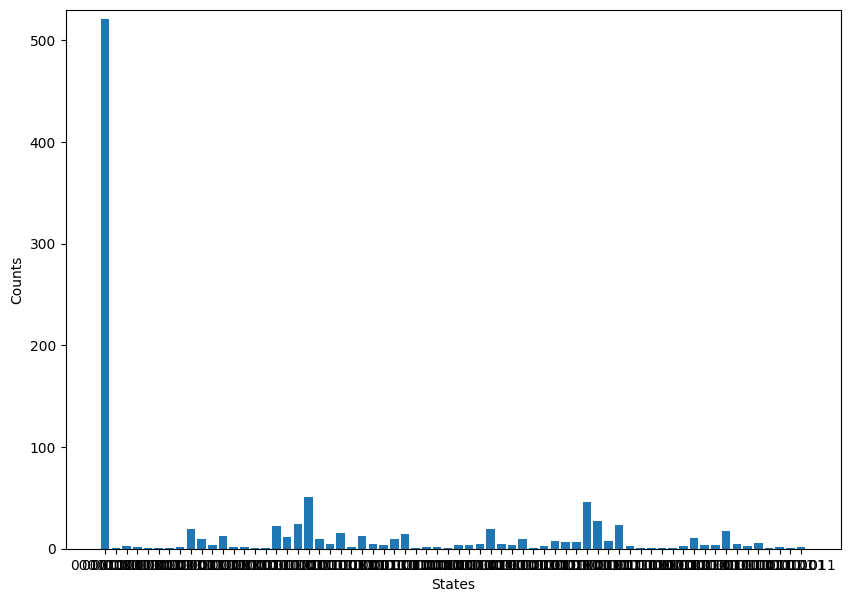

      ┌───┐                                                                »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────────»
      ├───┤       │                                                        »
 q_1: ┤ H ├───────┼───────────────■────────────────────────────────────────»
      ├───┤       │               │                                        »
 q_2: ┤ H ├───────┼───────────────┼───────────────■────────────────────────»
      ├───┤       │               │               │                        »
 q_3: ┤ H ├───────┼───────────────┼───────────────┼───────────────■────────»
      ├───┤       │               │               │               │        »
 q_4: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────»
      ├───┤       │               │               │               │        »
 q_5: ┤ H ├───────┼───────────────┼───────────────┼───────────────┼────────»
      ├───┤       │               │               │               │        »

In [11]:
# Run on a small number
N = 15
gcounts = shor(N)
print(gcounts)

In [12]:
from math import gcd
from fractions import Fraction

def get_factors_from_counts(counts, a, N, t):
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

    for measured_bits, _ in sorted_counts:
        y = int(measured_bits, 2)
        if y == 0:
            continue  # skip |000...0⟩

        phase = y / (2 ** t)
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        print("r = "+str(r))
        if r % 2 != 0:
            continue
        if pow(a, r, N) == 1:
            continue

        # Try getting factors
        plus = pow(a, r // 2, N) + 1
        minus = pow(a, r // 2, N) - 1
        factor1 = gcd(plus, N)
        factor2 = gcd(minus, N)

        if factor1 * factor2 == N and factor1 not in [1, N] and factor2 not in [1, N]:
            return factor1, factor2

    return None

In [13]:
    factors = get_factors_from_counts(gcounts, 11, N, N.bit_length() * 2)
    if factors:
        print(f"Success: {N} = {factors[0]} × {factors[1]}")

r = 3
r = 3
r = 3
r = 3
r = 10
r = 10
r = 6
r = 12
r = 6
r = 14
r = 7
r = 5
r = 5
r = 10
r = 5
r = 11
r = 3
r = 12
r = 5
r = 14
r = 10
r = 14
r = 3
r = 7
r = 14
r = 5
r = 7
r = 12
r = 13
r = 5
r = 12
r = 11
r = 9
r = 5
r = 5
r = 11
r = 11
r = 11
r = 7
r = 14
r = 13
r = 10
r = 13
r = 14
r = 15
r = 11
r = 9
r = 11
r = 10
r = 12
r = 12
r = 10
r = 7
r = 13
r = 11
r = 7
r = 9
r = 15
r = 13
r = 11
r = 15
r = 13
r = 9
r = 15
r = 11
